# Анализ источников привлечения пользователей игры

<b>Ссылка на презентацию:</b> https://drive.google.com/file/d/1ayD1ikGiw2PUWNETmZKTqE0CV7yJHEhl/view?usp=sharing

## Введение. 

В данном проекте предстоит сравнить время завершения уровня игроками в зависимости от способа прохождения. 

А также мы проанализируем окупаемость пользователей, в зависимости от источников привлечения. 

Выявленные различия проверим на предмет статистической значимости. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

from scipy import stats as st

import warnings # используется, чтобы не выводить на экран предупреждения
warnings.filterwarnings('ignore') 

Загрузим датасеты. 

In [3]:
game_actions = pd.read_csv('/datasets/game_actions.csv')

ad_costs = pd.read_csv('/datasets/ad_costs.csv')

user_source = pd.read_csv('/datasets/user_source.csv')

Познакомимся с таблицами: выведем на экран первые 5 строк каждой из них, а также посмотрим общую информацию о таблицах. Проверим на наличие явных дубликатов, изучим пропуски. Преобразуем форматы данных, где это требуется. 

#### Знакомство с таблицей "ad_costs":

In [4]:
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


Проверим таблицу "ad_costs" на наличие явных дубликатов. 

In [5]:
ad_costs.duplicated().sum()

0

In [6]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


Таблица "ad_costs" состоит из 3 столбцов и 28 строк. Пропусков в данных нет. 

Структура таблицы "ad_cost.csv":

- `day` - день, в который был совершен клик по объявлению

- `source` - источник трафика

- `cost` - стоимость кликов

Посчитаем суммарные расходы на рекламу для каждого канала привлечения: в дальнейшем нам пригодятся эти данные. 

In [7]:
ad_costs_pivot = ad_costs.pivot_table(index=['source'], values='cost', aggfunc=['sum'])
ad_costs_pivot = ad_costs_pivot.reset_index()
ad_costs_pivot.columns = ['source', 'ad_cost']
ad_costs_pivot

,source,ad_cost
0,facebook_ads,2140.904643
1,instagram_new_adverts,2161.441691
2,yandex_direct,2233.111449
3,youtube_channel_reklama,1068.119204


#### Знакомство с таблицей "user_source":

In [8]:
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Проверим таблицу "user_source" на наличие явных дубликатов. 

In [9]:
user_source.duplicated().sum()

0

In [10]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


Таблица "user_source" состоит из двух столбцов и 13576 строк. Пропусков в данных нет. 

Стурктура таблицы "user_source":

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

#### Знакомство с таблицей "game_actions":

In [11]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [12]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


Таблица "game_actions" содержит информацию о поведении пользователя в игре. Состоит из 5 столбцов и 135640 строк. 

Структура таблицы "game_actions":

- `event_datetime` — время события;


- `event` — одно из трёх событий:
    
    1. `building` — объект построен,
    
    2. `finished_stage_1` — первый уровень завершён,
    
    3. `project` — проект завершён;


- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;


- `user_id` — идентификатор пользователя;


- `project_type` — тип реализованного проекта;

Есть пропуски в столбцах building_type и project_type.

Проверим таблицу "game_actions" на наличие явных дубликатов. 

In [13]:
game_actions.duplicated().sum()

1

## Предварительная обработка данных в таблице "game_actions". 

Независимо от причины появления дубликата, удалим его из таблицы.

In [14]:
print('Число строк в таблице "game_actions" до удаления явных дубликатов:', game_actions.shape[0])
game_actions = game_actions.drop_duplicates()
print('Число строк в таблице "game_actions" до удаления явных дубликатов:', game_actions.shape[0])

Число строк в таблице "game_actions" до удаления явных дубликатов: 135640
Число строк в таблице "game_actions" до удаления явных дубликатов: 135639


Определим количество уникальных пользователей в таблице. 

In [15]:
print('Количество уникальных пользователей:', game_actions['user_id'].nunique())

Количество уникальных пользователей: 13576


Разберемся с пропусками. Создадим отдельную таблицу, в которой будут строки из таблицы game_actions с пропусками в столбце building_type. Выведем на экран. 

In [16]:
game_actions_with_null = game_actions[game_actions['building_type'].isnull()]
game_actions_with_null = game_actions_with_null.sort_values(by='event', ascending=False)
game_actions_with_null

,event_datetime,event,building_type,user_id,project_type
119525,2020-05-16 21:17:44,project,NaN,8b454f0d-d413-45ab-90b4-20efc7b9a9bb,satellite_orbital_assembly
131287,2020-05-21 04:35:06,project,NaN,5327c125-9d30-474e-a346-444014028201,satellite_orbital_assembly
131323,2020-05-21 05:04:50,project,NaN,966a5565-f858-40e3-a4e6-92039c1628e0,satellite_orbital_assembly
131320,2020-05-21 04:58:49,project,NaN,6cc0824f-15d6-4cdf-a99f-768aa90706e0,satellite_orbital_assembly
126062,2020-05-18 17:01:08,project,NaN,3d8b488a-8b6e-428b-a34c-7dab7f617f61,satellite_orbital_assembly
...,...,...,...,...,...
114087,2020-05-15 20:18:22,finished_stage_1,NaN,0ebf4e00-2ab2-481e-b9ce-c57e8c3f40df,NaN
114076,2020-05-15 20:15:32,finished_stage_1,NaN,598586cd-ebe3-4c37-abb5-fa221293c6e1,NaN
114072,2020-05-15 20:15:15,finished_stage_1,NaN,48af1220-6e24-4a1b-919d-86dc5af0a5ee,NaN
114050,2020-05-15 20:09:55,finished_stage_1,NaN,d5417da4-cfcc-470a-8f8b-8f465b4de2ce,NaN


Мы видим, что пропуски в столбце building_type соответствуют значениям project и finished_stage_1 столбца event. Никаких действий с пропусками в столбце building_type предпринимать не требуется, равно как и с пропусками в столбце project_type (данные из этого столбца не будут использованы в дальнейшем анализе).

Преобразуем данные в столбце event_datetime в 'datetime', полученные значения запишем в отдельный столбец 'event_dt'. Из столбца 'event_dt' извлечем дату, запишем результат в столбец 'only_date'. 

Преобразуем данные в столбце only_date в формат "datetime". Удалим столбцы event_datetime и event_dt, а также столбец project_type. 

In [17]:
game_actions['event_dt'] = pd.to_datetime(game_actions['event_datetime']) 
game_actions['only_date'] = pd.to_datetime(game_actions['event_dt']).dt.date
game_actions['only_date'] = pd.to_datetime(game_actions['only_date']) 
game_actions = game_actions.drop(columns = ['event_datetime', 'event_dt', 'project_type'])

## Подготовка данных для сравнения времени завершения уровня игроками в зависимости от способа прохождения. 

Для дальнейшего анализа нас будут интересовать пользователи, завершившие первый уровень (т.е. пользователи, у которых в столбце event есть значение finished_stage_1). Создадим таблицы с такими пользователями и выведем ее на экран.

In [18]:
game_actions_finished_stage_1 = game_actions.loc[game_actions.loc[:,'event'] == 'finished_stage_1']
game_actions_finished_stage_1

,event,building_type,user_id,only_date
6659,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04
13134,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,2020-05-05
15274,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,2020-05-05
16284,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,2020-05-05
19650,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,2020-05-06
...,...,...,...,...
135632,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,2020-06-04
135633,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,2020-06-04
135636,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,2020-06-05
135638,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,2020-06-05


Получилась таблица с 5817 строками. Таково количество уникальных пользователей, оставшихся в таблице. Мы потеряли данные о других событиях из столбца event для каждого из оставшихся пользователей. 

Для восстановления потерянных данных объединим таблицы "game_actions_finished_stage_1" и "game_actions" по переменной user_id. Полученную таблицу выведем на экран.  

In [19]:
game_actions_finished_stage_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5817 entries, 6659 to 135639
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   event          5817 non-null   object        
 1   building_type  0 non-null      object        
 2   user_id        5817 non-null   object        
 3   only_date      5817 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 227.2+ KB


In [20]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   event          135639 non-null  object        
 1   building_type  127956 non-null  object        
 2   user_id        135639 non-null  object        
 3   only_date      135639 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 5.2+ MB


In [85]:
game_actions_finished_stage_1_result = game_actions_finished_stage_1.merge(game_actions, on=['user_id'], how='left')

game_actions_finished_stage_1_result

,event_x,building_type_x,user_id,only_date_x,event_y,building_type_y,only_date_y
0,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,building,assembly_shop,2020-05-04
1,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,building,spaceport,2020-05-04
2,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,finished_stage_1,NaN,2020-05-04
3,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,2020-05-05,building,assembly_shop,2020-05-04
4,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,2020-05-05,building,spaceport,2020-05-04
...,...,...,...,...,...,...,...
68464,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,building,spaceport,2020-05-29
68465,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,building,spaceport,2020-05-30
68466,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,building,spaceport,2020-06-02
68467,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,building,research_center,2020-06-05


Удалим лишние столбцы: 'event_x', 'building_type_x', 'only_date_x'. Результат выведем на экран.

In [86]:
game_actions_finished_stage_1_result = game_actions_finished_stage_1_result.drop(columns = ['event_x', 'building_type_x', 'only_date_x'])

game_actions_finished_stage_1_result.columns = ('user_id', 'event', 'building_type', 'only_date')

game_actions_finished_stage_1_result

,user_id,event,building_type,only_date
0,ced7b368-818f-48f6-9461-2346de0892c5,building,assembly_shop,2020-05-04
1,ced7b368-818f-48f6-9461-2346de0892c5,building,spaceport,2020-05-04
2,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,NaN,2020-05-04
3,7ef7fc89-2779-46ea-b328-9e5035b83af5,building,assembly_shop,2020-05-04
4,7ef7fc89-2779-46ea-b328-9e5035b83af5,building,spaceport,2020-05-04
...,...,...,...,...
68464,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-05-29
68465,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-05-30
68466,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-06-02
68467,f21d179f-1c4b-437e-b9c6-ab1976907195,building,research_center,2020-06-05


Проверим количество уникальных пользователей в таблице: оно должно быть 5817. 

In [87]:
print('Количество уникальных пользователей:', game_actions_finished_stage_1_result['user_id'].nunique())

Количество уникальных пользователей: 5817


Таблица "game_actions_finished_stage_1_result" содержит информацию о пользователях, завершивших первый уровень. С помощью этой таблицы мы можем разделить пользователей в зависимости от способа прохождения первого уровня:

1) через реализацию проекта (такими будут пользователи, у которых в столбце event есть значение project),

2) через победу над первым игроком (такими будут пользователи, у которых в столбце event нет значения project, т.е. все остальные пользователи относительно первой группы).

Посмотрим, как часто встречается значение project в столбце event таблицы game_actions_finished_stage_1_result: таким будет количество уникальных пользователей, завершивших первый уровень через реализацию проекта). 

In [88]:
game_actions_finished_stage_1_result_values_count = game_actions_finished_stage_1_result['event'].value_counts()
game_actions_finished_stage_1_result_values_count

building            60786
finished_stage_1     5817
project              1866
Name: event, dtype: int64

Соответственно, количество пользователей, завершивших первый уровень через победу над первым игроком, будет:

In [89]:
game_actions_finished_stage_1_result['user_id'].nunique() - game_actions_finished_stage_1_result['event'].value_counts()['project']

3951

Напишем функцию, которая в новом столбце каждой строке присвоит значение project или win в зависимости от значения в столбце event.

In [90]:
def finish_type(row):
    if row ['event'] == 'project':
        return 'project'
    else:
        return 'win'

game_actions_finished_stage_1_result['finish_type'] = game_actions_finished_stage_1_result.apply(finish_type, axis=1)
game_actions_finished_stage_1_result

,user_id,event,building_type,only_date,finish_type
0,ced7b368-818f-48f6-9461-2346de0892c5,building,assembly_shop,2020-05-04,win
1,ced7b368-818f-48f6-9461-2346de0892c5,building,spaceport,2020-05-04,win
2,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,NaN,2020-05-04,win
3,7ef7fc89-2779-46ea-b328-9e5035b83af5,building,assembly_shop,2020-05-04,win
4,7ef7fc89-2779-46ea-b328-9e5035b83af5,building,spaceport,2020-05-04,win
...,...,...,...,...,...
68464,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-05-29,win
68465,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-05-30,win
68466,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-06-02,win
68467,f21d179f-1c4b-437e-b9c6-ab1976907195,building,research_center,2020-06-05,win


Для определения даты начала использования приложения каждым пользователем, завершившим первый уровень, создадим сводную таблицу. 

In [91]:
game_actions_finished_stage_1_result_pivot_min = game_actions_finished_stage_1_result.pivot_table(index=['user_id'], values='only_date', aggfunc=['min'])
game_actions_finished_stage_1_result_pivot_min = game_actions_finished_stage_1_result_pivot_min.reset_index()
game_actions_finished_stage_1_result_pivot_min.columns = ['user_id', 'start_date']
game_actions_finished_stage_1_result_pivot_min

,user_id,start_date
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10
...,...,...
5812,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,2020-05-06
5813,ffe810f4-1a1f-464b-924d-6f120b0cb8df,2020-05-04
5814,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04
5815,fffb626c-5ab6-47c9-8113-2062a2f18494,2020-05-04


Сейчас таблица game_actions_finished_stage_1_result содержит все записи о событиях. Отберем только те из них, в которых в столбце event указано finished_stage_1: так в таблице останутся даты завершения первого уровня. 

In [92]:
game_actions_finished_stage_1_result_finish = game_actions_finished_stage_1_result.loc[game_actions_finished_stage_1_result.loc[:,'event'] == 'finished_stage_1']

game_actions_finished_stage_1_result_finish

,user_id,event,building_type,only_date,finish_type
2,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,NaN,2020-05-04,win
5,7ef7fc89-2779-46ea-b328-9e5035b83af5,finished_stage_1,NaN,2020-05-05,win
8,70db22b3-c2f4-43bc-94ea-51c8d2904a29,finished_stage_1,NaN,2020-05-05,win
12,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,finished_stage_1,NaN,2020-05-05,win
15,58e077ba-feb1-4556-a5a0-d96bd04efa39,finished_stage_1,NaN,2020-05-06,win
...,...,...,...,...,...
68410,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1,NaN,2020-06-04,win
68425,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,finished_stage_1,NaN,2020-06-04,win
68438,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1,NaN,2020-06-05,win
68455,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1,NaN,2020-06-05,win


Полученную таблицу объединим с таблицей game_actions_finished_stage_1_result_pivot_min (она содержит даты начала использования приложения). Столбец only_date переименуем в finish_date - это будет дата завершения уровня. 

In [93]:
game_actions_finished_stage_1_result_merged = game_actions_finished_stage_1_result_finish.merge(game_actions_finished_stage_1_result_pivot_min, on=['user_id'], how='inner')

    game_actions_finished_stage_1_result_merged.rename(columns={'only_date': 'finish_date'}, inplace=True)

game_actions_finished_stage_1_result_merged

,user_id,event,building_type,finish_date,finish_type,start_date
0,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,NaN,2020-05-04,win,2020-05-04
1,7ef7fc89-2779-46ea-b328-9e5035b83af5,finished_stage_1,NaN,2020-05-05,win,2020-05-04
2,70db22b3-c2f4-43bc-94ea-51c8d2904a29,finished_stage_1,NaN,2020-05-05,win,2020-05-04
3,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,finished_stage_1,NaN,2020-05-05,win,2020-05-04
4,58e077ba-feb1-4556-a5a0-d96bd04efa39,finished_stage_1,NaN,2020-05-06,win,2020-05-04
...,...,...,...,...,...,...
5812,22cce310-fe10-41a2-941b-9c3d63327fea,finished_stage_1,NaN,2020-06-04,win,2020-05-04
5813,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,finished_stage_1,NaN,2020-06-04,win,2020-05-07
5814,515c1952-99aa-4bca-a7ea-d0449eb5385a,finished_stage_1,NaN,2020-06-05,win,2020-05-07
5815,32572adb-900f-4b5d-a453-1eb1e6d88d8b,finished_stage_1,NaN,2020-06-05,win,2020-05-07


Удалим лишние столбцы: 'finish_type', 'event', 'building_type'.

In [94]:
game_actions_finished_stage_1_result_merged = game_actions_finished_stage_1_result_merged.drop(columns = ['finish_type', 'event', 'building_type']) 
game_actions_finished_stage_1_result_merged

,user_id,finish_date,start_date
0,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,2020-05-04
1,7ef7fc89-2779-46ea-b328-9e5035b83af5,2020-05-05,2020-05-04
2,70db22b3-c2f4-43bc-94ea-51c8d2904a29,2020-05-05,2020-05-04
3,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,2020-05-05,2020-05-04
4,58e077ba-feb1-4556-a5a0-d96bd04efa39,2020-05-06,2020-05-04
...,...,...,...
5812,22cce310-fe10-41a2-941b-9c3d63327fea,2020-06-04,2020-05-04
5813,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,2020-06-04,2020-05-07
5814,515c1952-99aa-4bca-a7ea-d0449eb5385a,2020-06-05,2020-05-07
5815,32572adb-900f-4b5d-a453-1eb1e6d88d8b,2020-06-05,2020-05-07


Сейчас таблица game_actions_finished_stage_1_result_merged содержит информацию о 5817 уникальных пользователях, завершивших первый уровень, а именно их идентификатор и даты начала и завершения первого уровня. Для каждого пользователя необходимо добавить информацию о способе прохождения. 

Для этого полученную таблицу game_actions_finished_stage_1_result_merged объединим с таблицей game_actions_finished_stage_1_result (для нас представляет интерес столбец event).

In [95]:
game_actions_finished_stage_1_result_merged_final = game_actions_finished_stage_1_result_merged.merge(game_actions_finished_stage_1_result, on=['user_id'], how='left')
game_actions_finished_stage_1_result_merged_final

,user_id,finish_date,start_date,event,building_type,only_date,finish_type
0,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,2020-05-04,building,assembly_shop,2020-05-04,win
1,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,2020-05-04,building,spaceport,2020-05-04,win
2,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,2020-05-04,finished_stage_1,NaN,2020-05-04,win
3,7ef7fc89-2779-46ea-b328-9e5035b83af5,2020-05-05,2020-05-04,building,assembly_shop,2020-05-04,win
4,7ef7fc89-2779-46ea-b328-9e5035b83af5,2020-05-05,2020-05-04,building,spaceport,2020-05-04,win
...,...,...,...,...,...,...,...
68464,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,2020-05-06,building,spaceport,2020-05-29,win
68465,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,2020-05-06,building,spaceport,2020-05-30,win
68466,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,2020-05-06,building,spaceport,2020-06-02,win
68467,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,2020-05-06,building,research_center,2020-06-05,win


В полученной таблице оставим только те строки, где в столбце event указано finished_stage_1. Удалим лишние столбцы. 

In [96]:
game_actions_finished_stage_1_result_merged_final = game_actions_finished_stage_1_result_merged_final.loc[game_actions_finished_stage_1_result_merged_final.loc[:,'event'] == 'finished_stage_1']

game_actions_finished_stage_1_result_merged_final = game_actions_finished_stage_1_result_merged_final.drop(columns = ['finish_type', 'only_date', 'building_type']) 

game_actions_finished_stage_1_result_merged_final

,user_id,finish_date,start_date,event
2,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,2020-05-04,finished_stage_1
5,7ef7fc89-2779-46ea-b328-9e5035b83af5,2020-05-05,2020-05-04,finished_stage_1
8,70db22b3-c2f4-43bc-94ea-51c8d2904a29,2020-05-05,2020-05-04,finished_stage_1
12,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,2020-05-05,2020-05-04,finished_stage_1
15,58e077ba-feb1-4556-a5a0-d96bd04efa39,2020-05-06,2020-05-04,finished_stage_1
...,...,...,...,...
68410,22cce310-fe10-41a2-941b-9c3d63327fea,2020-06-04,2020-05-04,finished_stage_1
68425,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,2020-06-04,2020-05-07,finished_stage_1
68438,515c1952-99aa-4bca-a7ea-d0449eb5385a,2020-06-05,2020-05-07,finished_stage_1
68455,32572adb-900f-4b5d-a453-1eb1e6d88d8b,2020-06-05,2020-05-07,finished_stage_1


Отберем из таблицы game_actions_finished_stage_1_result только те записи, в которых в столбце finish_type указано project. 

In [97]:
game_actions_finished_stage_1_result_project = game_actions_finished_stage_1_result.loc[game_actions_finished_stage_1_result.loc[:,'finish_type'] == 'project']
game_actions_finished_stage_1_result_project

,user_id,event,building_type,only_date,finish_type
646,9e57e5bb-49f4-4efb-991c-747d7a88e446,project,NaN,2020-05-10,project
949,e3c66498-9d45-4000-9392-f81e6796e7da,project,NaN,2020-05-08,project
1079,a4491c86-c498-4f74-a56e-65c136d0e9a1,project,NaN,2020-05-09,project
1794,9f63fad6-17b0-493f-938b-8d19e6d6c38c,project,NaN,2020-05-10,project
2256,ee21905b-ab5a-44c6-9196-e5c9f8fada19,project,NaN,2020-05-11,project
...,...,...,...,...,...
68304,9df154c3-fb77-4f8a-a281-0457c0b11cec,project,NaN,2020-05-29,project
68322,9d98001c-7e14-40d7-896e-46b3047365fd,project,NaN,2020-06-02,project
68346,82e46f34-e243-4728-8e20-2e171fc33ea4,project,NaN,2020-06-02,project
68396,fe032991-71e0-48c5-889f-4c3805ba4c9b,project,NaN,2020-06-03,project


Объединим полученную таблицу и таблицу game_actions_finished_stage_1_result_merged_final, удалим лишние столбцы, а пропущенные значения в столбце finish_type заменим на значение "win" (так обозначим тех пользователей, которые завершили уровень через победу над первым игроком). 

In [98]:
for_1_hyp = game_actions_finished_stage_1_result_merged_final.merge(game_actions_finished_stage_1_result_project, on=['user_id'], how='left')
for_1_hyp = for_1_hyp.drop(columns = ['event_x', 'event_y', 'building_type', 'only_date'])
for_1_hyp['finish_type'] = for_1_hyp['finish_type'].fillna('win')
for_1_hyp['finish_type'].value_counts()

win        3951
project    1866
Name: finish_type, dtype: int64

Мы видим, что количество игроков со значениями win и project в столбце finish_type соответствует выполненным ранее расчетам. 

Выведем на экран полученную таблицу. 

In [99]:
for_1_hyp

,user_id,finish_date,start_date,finish_type
0,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04,2020-05-04,win
1,7ef7fc89-2779-46ea-b328-9e5035b83af5,2020-05-05,2020-05-04,win
2,70db22b3-c2f4-43bc-94ea-51c8d2904a29,2020-05-05,2020-05-04,win
3,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,2020-05-05,2020-05-04,win
4,58e077ba-feb1-4556-a5a0-d96bd04efa39,2020-05-06,2020-05-04,win
...,...,...,...,...
5812,22cce310-fe10-41a2-941b-9c3d63327fea,2020-06-04,2020-05-04,win
5813,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,2020-06-04,2020-05-07,project
5814,515c1952-99aa-4bca-a7ea-d0449eb5385a,2020-06-05,2020-05-07,win
5815,32572adb-900f-4b5d-a453-1eb1e6d88d8b,2020-06-05,2020-05-07,win


Рассчитаем время прохождения первого уровня. Полученное значение поместим в столбец time. Преобразуем формат данных в столбце time в integer. Полученные целочисленные значения в столбце time увеличим на 1 (это нужно сделать, чтобы первый день завершения уровня считать как 1 день, а не 0). 

Удалим лишние столбцы из таблицы. 

In [100]:
for_1_hyp['time'] = for_1_hyp['finish_date'] - for_1_hyp['start_date']
for_1_hyp['time'] = pd.to_numeric(for_1_hyp['time'].dt.days, downcast='integer')
for_1_hyp['time'] = for_1_hyp['time'] + 1
for_1_hyp = for_1_hyp.drop(columns = ['finish_date', 'start_date']) 
for_1_hyp

,user_id,finish_type,time
0,ced7b368-818f-48f6-9461-2346de0892c5,win,1
1,7ef7fc89-2779-46ea-b328-9e5035b83af5,win,2
2,70db22b3-c2f4-43bc-94ea-51c8d2904a29,win,2
3,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,win,2
4,58e077ba-feb1-4556-a5a0-d96bd04efa39,win,3
...,...,...,...
5812,22cce310-fe10-41a2-941b-9c3d63327fea,win,32
5813,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,project,29
5814,515c1952-99aa-4bca-a7ea-d0449eb5385a,win,30
5815,32572adb-900f-4b5d-a453-1eb1e6d88d8b,win,30


<b>Данные из таблицы for_1_hyp будут использованы для сравнения времени завершения первого уровня в зависимости от способа прохождения.</b> 

Сейчас посмотрим, как отличаются средние значения времени прохождения первого уровня в зависимости от способа прохождения. 

In [101]:
for_1_hyp_pivot = for_1_hyp.pivot_table(index=['finish_type'], values='time', aggfunc=['mean'])
for_1_hyp_pivot = for_1_hyp_pivot.reset_index()
for_1_hyp_pivot.columns = ['finish_type', 'mean_time']
for_1_hyp_pivot['mean_time'] = np.round(for_1_hyp_pivot['mean_time'], decimals = 1)
for_1_hyp_pivot

,finish_type,mean_time
0,project,14.4
1,win,12.1


<b>Среднее время прохождения первого уровня через победу над первым игроком меньше, чем через реализацию проекта.</b>

В разделе "Проверка гипотез" мы узнаем, является ли это различие статистически значимым. 

## Анализ времени прохождения уровня.

Построим гистограмму с частотным распределением данных по переменной "time" ("Количество дней на прохождение уровня"), с учетом выбранного способа прохождения.

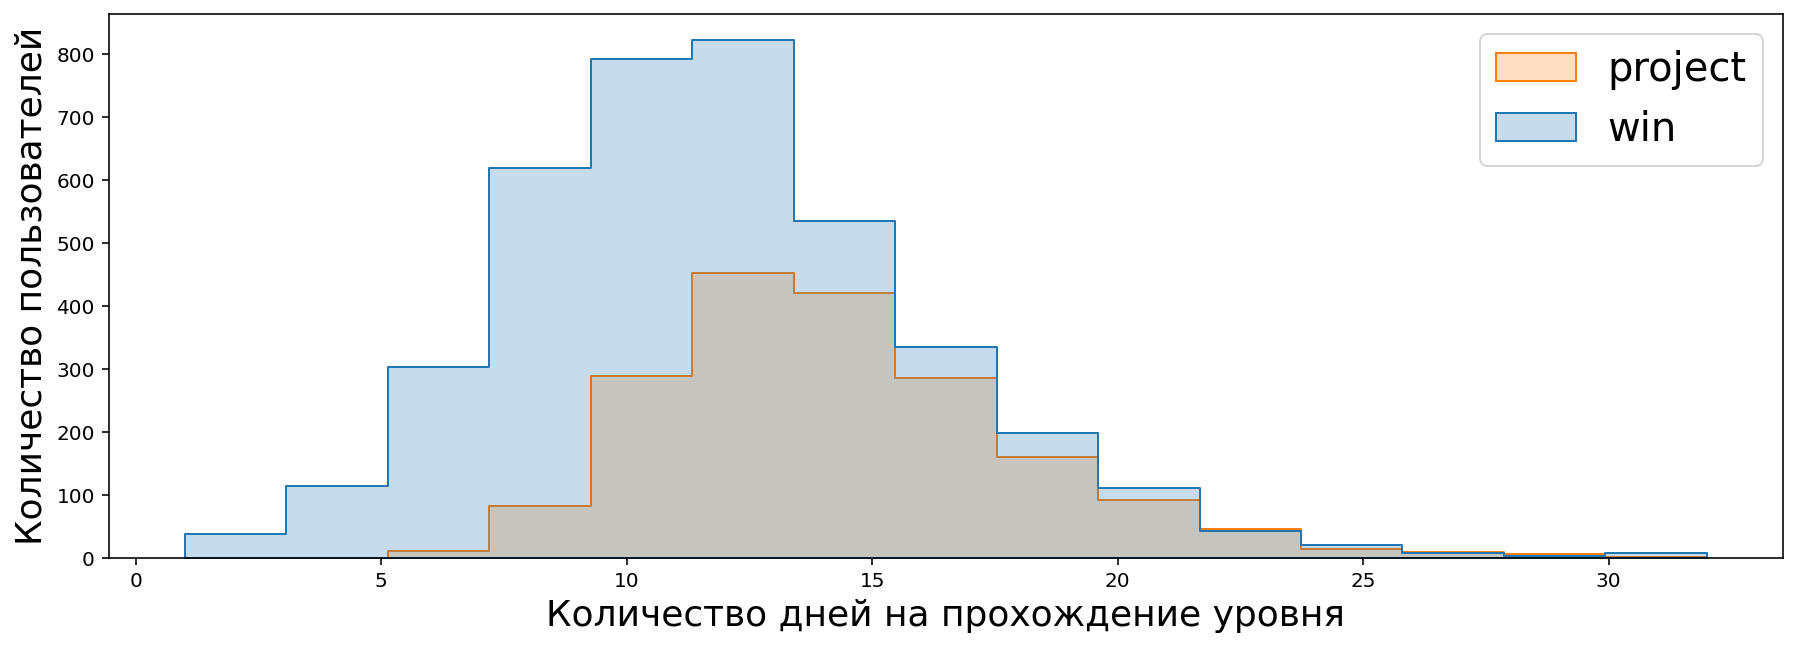

In [102]:
plt.figure(figsize=(15, 5))
sns.histplot(x="time", data=for_1_hyp, hue="finish_type", element="step", bins=15)
plt.xlabel('Количество дней на прохождение уровня', fontsize = 18)
plt.ylabel ('Количество пользователей', fontsize = 18)
plt.legend(['project', 'win'], fontsize=20)
plt.show();

Для каждого способа прохождения уровня характерной длительностью прохождения является интервал от 10 до 15 дней. 

Проверим, есть ли аномальные значения в столбце 'time' в каждой из двух групп пользователей в зависимости от способа прохождения.

Сначала создадим два отдельных массива. 

In [103]:
for_1_hyp_win = for_1_hyp.loc[for_1_hyp.loc[:,'finish_type'] == 'win']
for_1_hyp_project = for_1_hyp.loc[for_1_hyp.loc[:,'finish_type'] == 'project']

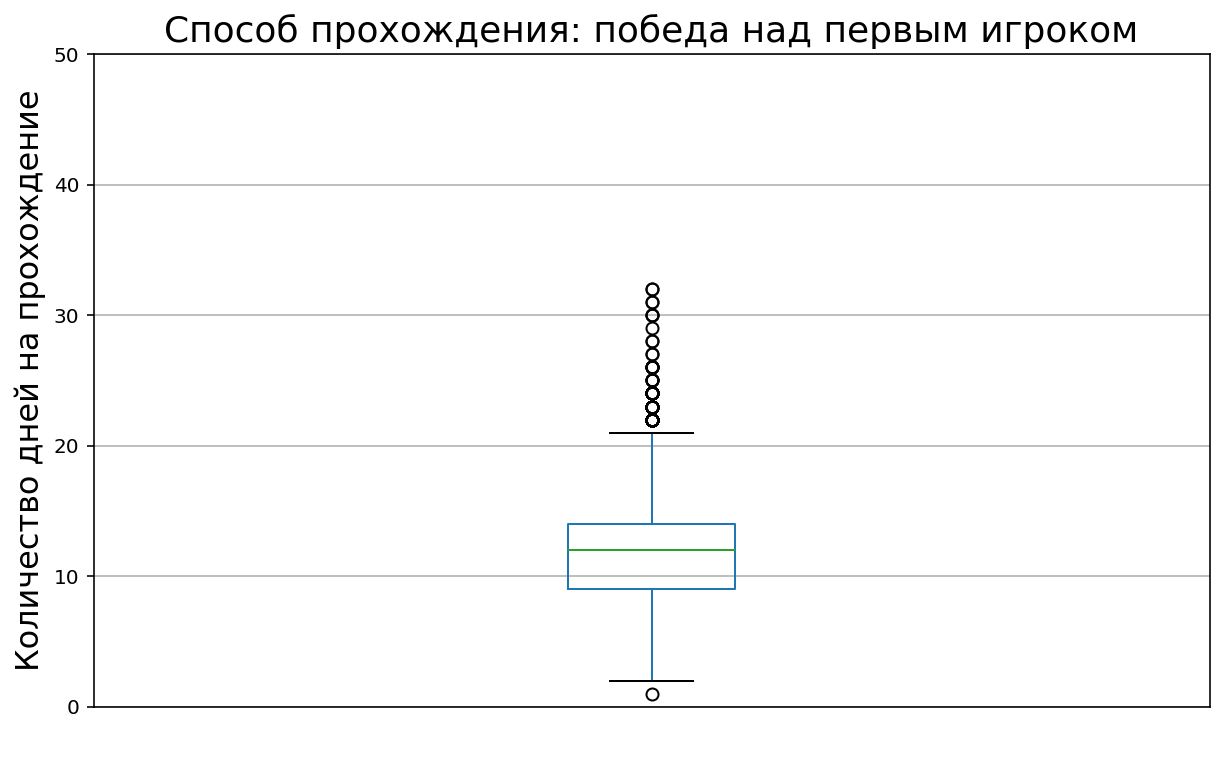

In [104]:
plt.figure(figsize=(10, 6))
for_1_hyp_win.boxplot(column = 'time')
plt.xticks([])
plt.ylim(0, 50)
plt.title('Способ прохождения: победа над первым игроком', fontsize=18)
plt.xlabel(' ', fontsize=16)
plt.ylabel('Количество дней на прохождение', fontsize=16);

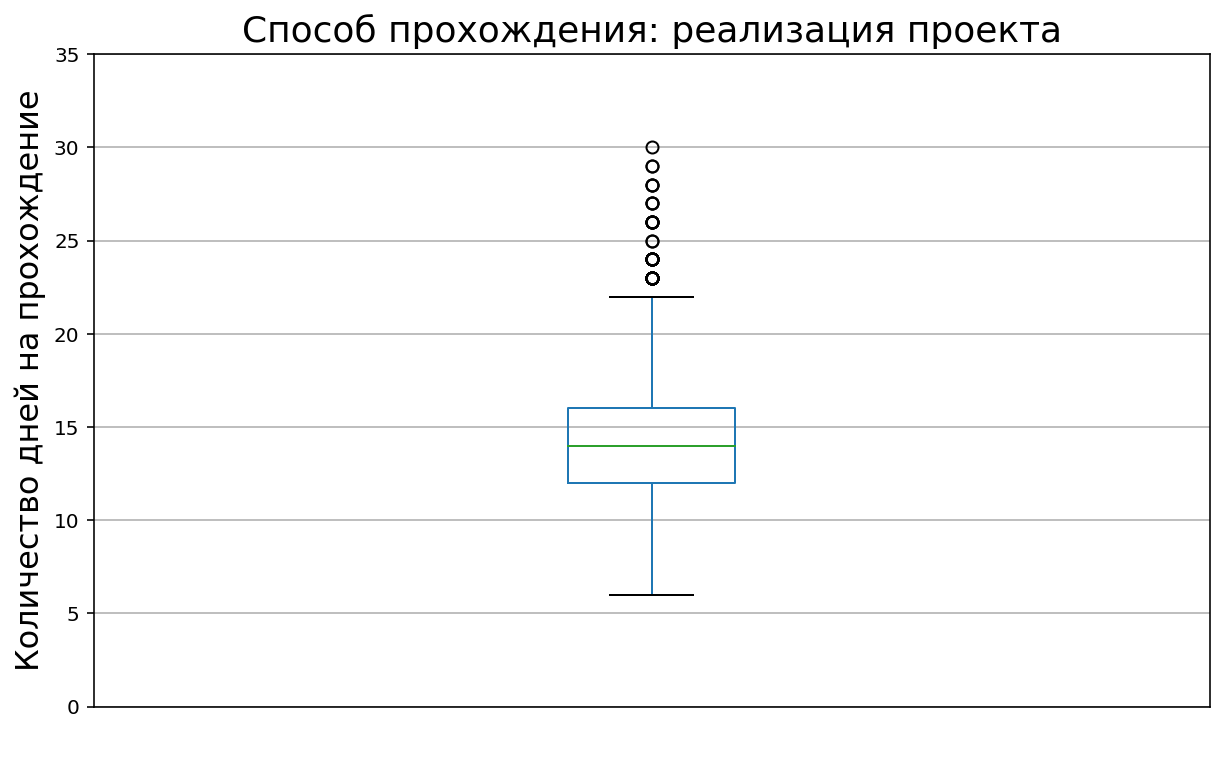

In [105]:
plt.figure(figsize=(10, 6))
for_1_hyp_project.boxplot(column = 'time')
plt.xticks([])
plt.ylim(0, 35)
plt.title('Способ прохождения: реализация проекта', fontsize=18)
plt.xlabel(' ', fontsize=16)
plt.ylabel('Количество дней на прохождение', fontsize=16);

Значения за пределами верхнего и нижнего "усов" распределены равномерно и близко к "усам", поэтому считать их выбросами нельзя: все наблюдения оставляем. 

##  Анализ окупаемости пользователей, в зависимости от источников их привлечения.

### Оценка окупаемости каналов привлечения.

Создадим функцию, которая в новом столбце building_count каждой строке таблицы game_actions присвоит значение "0" или "1" в зависимости от значения в столбце event (1, если event = building, 0 - в остальных случаях). 

Затем создадим сводную таблицу, в которой посчитаем сумму значений в столбце building_count для каждого уникального user_id: таким образом узнаем частоту показа рекламы на экране с выбором типа объекта для постройки. 

In [106]:
def building(row):
    if row ['event'] == 'building':
        return 1
    else:
        return 0

game_actions['building_count'] = game_actions.apply(building, axis=1)
game_actions

,event,building_type,user_id,only_date,building_count
0,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,1
1,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-04,1
2,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,2020-05-04,1
3,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,2020-05-04,1
4,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,2020-05-04,1
...,...,...,...,...,...
135635,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,2020-06-05,1
135636,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,2020-06-05,0
135637,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,2020-06-05,1
135638,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,2020-06-05,0


In [107]:
game_actions_pivot = game_actions.pivot_table(index=['user_id'], values='building_count', aggfunc=['sum'])
game_actions_pivot = game_actions_pivot.reset_index()
game_actions_pivot.columns = ['user_id', 'ad_shows_count']
game_actions_pivot

,user_id,ad_shows_count
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8
4,002f508f-67b6-479f-814b-b05f00d4e995,12
...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,9
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,7


Объединим таблицу "game_actions_pivot" с таблицей "user_source". 

In [108]:
for_2_hyp = game_actions_pivot.merge(user_source, on=['user_id'], how='left')
for_2_hyp

,user_id,ad_shows_count,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,12,facebook_ads
...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,9,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,7,instagram_new_adverts


Построим сводную таблицу, в которой покажем суммарное количество показов рекламы пользователям, в зависимости от канала их привлечения. 

In [109]:
for_2_hyp_pivot_1 = for_2_hyp.pivot_table(index=['source'], values='ad_shows_count', aggfunc=['sum'])
for_2_hyp_pivot_1 = for_2_hyp_pivot_1.reset_index()
for_2_hyp_pivot_1.columns = ['source', 'total_ad_shows_count']
for_2_hyp_pivot_1

,source,total_ad_shows_count
0,facebook_ads,26131
1,instagram_new_adverts,31815
2,yandex_direct,45032
3,youtube_channel_reklama,24978


Объединим таблицы for_2_hyp_pivot_1 и ad_costs_pivot.

In [110]:
for_2_hyp_pivot_merged = for_2_hyp_pivot_1.merge(ad_costs_pivot, on=['source'], how='inner')
for_2_hyp_pivot_merged

,source,total_ad_shows_count,ad_cost
0,facebook_ads,26131,2140.904643
1,instagram_new_adverts,31815,2161.441691
2,yandex_direct,45032,2233.111449
3,youtube_channel_reklama,24978,1068.119204


Нам известно, что доход от одного показа рекламы составляет 0,07. Рассчитаем суммарный доход от пользователей, в зависимости от канала их привлечения, а также разницу между доходом и суммарной стоимостью привлечения для каждого источника. 

In [111]:
profit_for_one = 0.07
for_2_hyp_pivot_merged['profit'] = for_2_hyp_pivot_merged['total_ad_shows_count'] * profit_for_one
for_2_hyp_pivot_merged['difference'] = for_2_hyp_pivot_merged['profit'] - for_2_hyp_pivot_merged['ad_cost'] 
for_2_hyp_pivot_merged

,source,total_ad_shows_count,ad_cost,profit,difference
0,facebook_ads,26131,2140.904643,1829.17,-311.734643
1,instagram_new_adverts,31815,2161.441691,2227.05,65.608309
2,yandex_direct,45032,2233.111449,3152.24,919.128551
3,youtube_channel_reklama,24978,1068.119204,1748.46,680.340796


Основываясь на имеющихся в нашем распоряжении данных обо всех пользователях, установивших приложение, можно сделать вывод о том, что за исследуемый период <b>реклама в facebook_ads не окупилась</b>. Лучше всего окупились расходы на привлечение из yandex_direct. 



### Оценка окупаемость игроков, в зависимости от каналов привлечения. 

Добавим в таблицу for_2_hyp_pivot_merged данные о количестве пользователей, привлечененных с помощью каждого из каналов, а также прибыль, которую, в среднем, приносит каждый пользователь. 

In [112]:
user_source_values_count = user_source['source'].value_counts()

 
user_source_values_count = pd.DataFrame(user_source_values_count)  

user_source_values_count = user_source_values_count.reset_index()
user_source_values_count.columns = ['source', 'count_users']


for_2_hyp_pivot_merged_merged = for_2_hyp_pivot_merged.merge(user_source_values_count, on=['source'], how='inner')

for_2_hyp_pivot_merged_merged['difference_per_user'] = for_2_hyp_pivot_merged_merged['difference'] / for_2_hyp_pivot_merged_merged['count_users']



for_2_hyp_pivot_merged_merged = for_2_hyp_pivot_merged_merged.sort_values(by='difference_per_user', ascending=False)
for_2_hyp_pivot_merged_merged

,source,total_ad_shows_count,ad_cost,profit,difference,count_users,difference_per_user
3,youtube_channel_reklama,24978,1068.119204,1748.46,680.340796,2686,0.253291
2,yandex_direct,45032,2233.111449,3152.24,919.128551,4817,0.190809
1,instagram_new_adverts,31815,2161.441691,2227.05,65.608309,3347,0.019602
0,facebook_ads,26131,2140.904643,1829.17,-311.734643,2726,-0.114356


<b>Наибольшая средняя прибыльность у игроков, привлеченных из youtube_channel_reklama, на втором месте - yandex_direct.</b> 

#### Подготовка данных для сравнения средних значений прибыли от пользователя, в зависимости от канала привлечения: из youtube_channel_reklama или из yandex_direct. 

Рассчитаем среднюю стоимость привлечения одного игрока, в зависимости от источника. 

In [113]:
for_2_hyp_pivot_merged_merged['mean_cost'] = for_2_hyp_pivot_merged_merged['ad_cost'] / for_2_hyp_pivot_merged_merged['count_users']

for_2_hyp_pivot_merged_merged

,source,total_ad_shows_count,ad_cost,profit,difference,count_users,difference_per_user,mean_cost
3,youtube_channel_reklama,24978,1068.119204,1748.46,680.340796,2686,0.253291,0.397662
2,yandex_direct,45032,2233.111449,3152.24,919.128551,4817,0.190809,0.463590
1,instagram_new_adverts,31815,2161.441691,2227.05,65.608309,3347,0.019602,0.645785
0,facebook_ads,26131,2140.904643,1829.17,-311.734643,2726,-0.114356,0.785365


Объединим таблицы for_2_hyp и for_2_hyp_pivot_merged_merged, удалим лишние столбцы. Так мы получим таблицу, в которой будут содержаться данные о стоимости привлечения каждого пользователя, в зависимости от канала, а также количество переходов на экран с выбором типа объекта для постройки.

In [114]:
for_2_hyp_merged = for_2_hyp.merge(for_2_hyp_pivot_merged_merged, on=['source'], how='left')

for_2_hyp_merged = for_2_hyp_merged.loc[:, ['user_id', 'source', 'ad_shows_count', 'mean_cost']]
for_2_hyp_merged

,user_id,source,ad_shows_count,mean_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,13,0.785365
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,9,0.463590
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,4,0.397662
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8,0.645785
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,12,0.785365
...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,9,0.645785
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads,16,0.785365
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,9,0.463590
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,7,0.645785


Теперь мы можем рассчитать прибыль от каждого игрока. 

In [115]:
for_2_hyp_merged['profit'] = (for_2_hyp_merged['ad_shows_count'] * profit_for_one) - for_2_hyp_merged['mean_cost']
for_2_hyp_merged

,user_id,source,ad_shows_count,mean_cost,profit
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,13,0.785365,0.124635
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,9,0.463590,0.166410
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,4,0.397662,-0.117662
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8,0.645785,-0.085785
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,12,0.785365,0.054635
...,...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,9,0.645785,-0.015785
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads,16,0.785365,0.334635
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,9,0.463590,0.166410
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,7,0.645785,-0.155785


Оставим в таблице только данные о пользователях, привлеченных из yandex_direct и из youtube_channel_reklama. 

In [116]:
for_2_hyp_merged = for_2_hyp_merged.loc[~for_2_hyp_merged['source'].isin(['facebook_ads', 'instagram_new_adverts'])]

for_2_hyp_merged

,user_id,source,ad_shows_count,mean_cost,profit
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,9,0.463590,0.166410
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,4,0.397662,-0.117662
5,003b80c6-4164-4157-bb2a-03d0181d39c4,yandex_direct,14,0.463590,0.516410
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct,8,0.463590,0.096410
11,005ff87b-b475-4da7-862e-57ab91adbff4,youtube_channel_reklama,9,0.397662,0.232338
...,...,...,...,...,...
13567,ffcf62ae-0992-47ea-a010-2667ee0e7f23,yandex_direct,10,0.463590,0.236410
13568,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,yandex_direct,7,0.463590,0.026410
13569,ffd3469d-fb9e-49d8-84fe-c1a1aaf4b3b7,yandex_direct,11,0.463590,0.306410
13570,ffe810f4-1a1f-464b-924d-6f120b0cb8df,youtube_channel_reklama,16,0.397662,0.722338


Построим гистограмму с частотным распределением данных по переменной "profit", с учетом канала привлечения.

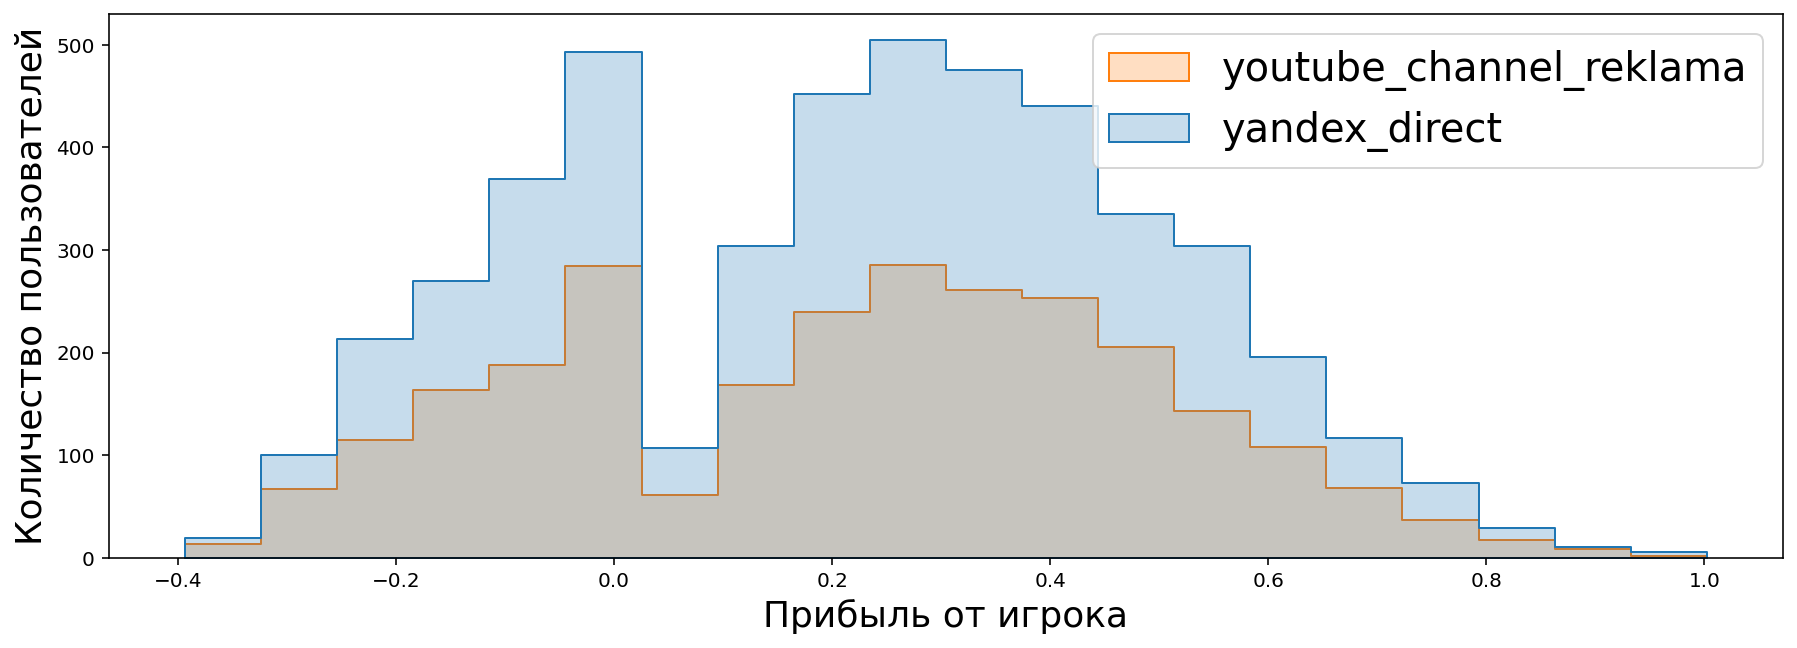

In [117]:
plt.figure(figsize=(15, 5))
sns.histplot(x="profit", data=for_2_hyp_merged, hue="source", element="step", bins=20)
plt.xlabel('Прибыль от игрока', fontsize = 18)
plt.ylabel ('Количество пользователей', fontsize = 18)
plt.legend(['youtube_channel_reklama', 'yandex_direct'], fontsize=20)
plt.show();

Оба распределения не выглядят, как нормальные: есть два пиковых значения. Поэтому при проверке статистической значимости различий средних прибылей дисперсии будем считать не равными. 

### Сравнение среднего количества событий "building" в зависимости от источника, с которого пришёл пользователь, завершивший первый уровень.

Применим функцию building к таблице game_actions_finished_stage_1_result.

In [118]:
game_actions_finished_stage_1_result['building_count'] = game_actions_finished_stage_1_result.apply(building, axis=1)
game_actions_finished_stage_1_result

,user_id,event,building_type,only_date,finish_type,building_count
0,ced7b368-818f-48f6-9461-2346de0892c5,building,assembly_shop,2020-05-04,win,1
1,ced7b368-818f-48f6-9461-2346de0892c5,building,spaceport,2020-05-04,win,1
2,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,NaN,2020-05-04,win,0
3,7ef7fc89-2779-46ea-b328-9e5035b83af5,building,assembly_shop,2020-05-04,win,1
4,7ef7fc89-2779-46ea-b328-9e5035b83af5,building,spaceport,2020-05-04,win,1
...,...,...,...,...,...,...
68464,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-05-29,win,1
68465,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-05-30,win,1
68466,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-06-02,win,1
68467,f21d179f-1c4b-437e-b9c6-ab1976907195,building,research_center,2020-06-05,win,1


Объединим таблицу game_actions_finished_stage_1_result с таблицей "user_source".

In [119]:
for_2_hyp_2 = game_actions_finished_stage_1_result.merge(user_source, on=['user_id'], how='left')
for_2_hyp_2

,user_id,event,building_type,only_date,finish_type,building_count,source
0,ced7b368-818f-48f6-9461-2346de0892c5,building,assembly_shop,2020-05-04,win,1,instagram_new_adverts
1,ced7b368-818f-48f6-9461-2346de0892c5,building,spaceport,2020-05-04,win,1,instagram_new_adverts
2,ced7b368-818f-48f6-9461-2346de0892c5,finished_stage_1,NaN,2020-05-04,win,0,instagram_new_adverts
3,7ef7fc89-2779-46ea-b328-9e5035b83af5,building,assembly_shop,2020-05-04,win,1,facebook_ads
4,7ef7fc89-2779-46ea-b328-9e5035b83af5,building,spaceport,2020-05-04,win,1,facebook_ads
...,...,...,...,...,...,...,...
68464,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-05-29,win,1,instagram_new_adverts
68465,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-05-30,win,1,instagram_new_adverts
68466,f21d179f-1c4b-437e-b9c6-ab1976907195,building,spaceport,2020-06-02,win,1,instagram_new_adverts
68467,f21d179f-1c4b-437e-b9c6-ab1976907195,building,research_center,2020-06-05,win,1,instagram_new_adverts


Построим сводную таблицу, в которой покажем суммарное количество событий building, в зависимости от канала их привлечения. Затем на основе полученной таблицы рассчитаем среднее количество событий building на одного пользователя в зависимости от канала привлечения.  

In [120]:
for_2_hyp_2_pivot = for_2_hyp_2.pivot_table(index=['user_id', 'source'], values='building_count', aggfunc=['sum'])
for_2_hyp_2_pivot = for_2_hyp_2_pivot.reset_index()
for_2_hyp_2_pivot.columns = ['user_id', 'source', 'total_ad_shows']
for_2_hyp_2_pivot

,user_id,source,total_ad_shows
0,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8
1,003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts,8
2,004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads,12
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct,8
4,0056c007-c082-43cc-bdef-afc49bca4cb9,instagram_new_adverts,3
...,...,...,...
5812,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,yandex_direct,7
5813,ffe810f4-1a1f-464b-924d-6f120b0cb8df,youtube_channel_reklama,16
5814,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,9
5815,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,9


In [121]:
for_2_hyp_2_pivot_2 = for_2_hyp_2_pivot.pivot_table(index=['source'], values='total_ad_shows', aggfunc=['mean'])
for_2_hyp_2_pivot_2 = for_2_hyp_2_pivot_2.reset_index()
for_2_hyp_2_pivot_2.columns = ['source', 'mean_ad_shows']
for_2_hyp_2_pivot_2['mean_ad_shows'] = np.round(for_2_hyp_2_pivot_2['mean_ad_shows'], decimals = 1)
for_2_hyp_2_pivot_2

,source,mean_ad_shows
0,facebook_ads,10.5
1,instagram_new_adverts,10.5
2,yandex_direct,10.4
3,youtube_channel_reklama,10.5


<b>Среднее количество событий building для завершивших первый уровень пользователей, привлеченных из yandex_direct, совсем незначительно уступает остальным каналам привлечения.</b> 

Построим гистограмму с частотным распределением данных по переменной "total_ad_shows" ("Количество переходов на экран с выбором типа объекта для постройки"), с учетом канала привлечения игрока.

In [122]:
def channel(row):
    if row ['source'] == 'yandex_direct':
        return 'yandex_direct'
    else:
        return 'other'

for_2_hyp_2_pivot['channel'] = for_2_hyp_2_pivot.apply(channel, axis=1)
for_2_hyp_2_pivot

,user_id,source,total_ad_shows,channel
0,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8,other
1,003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts,8,other
2,004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads,12,other
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct,8,yandex_direct
4,0056c007-c082-43cc-bdef-afc49bca4cb9,instagram_new_adverts,3,other
...,...,...,...,...
5812,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,yandex_direct,7,yandex_direct
5813,ffe810f4-1a1f-464b-924d-6f120b0cb8df,youtube_channel_reklama,16,other
5814,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,9,other
5815,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,9,yandex_direct


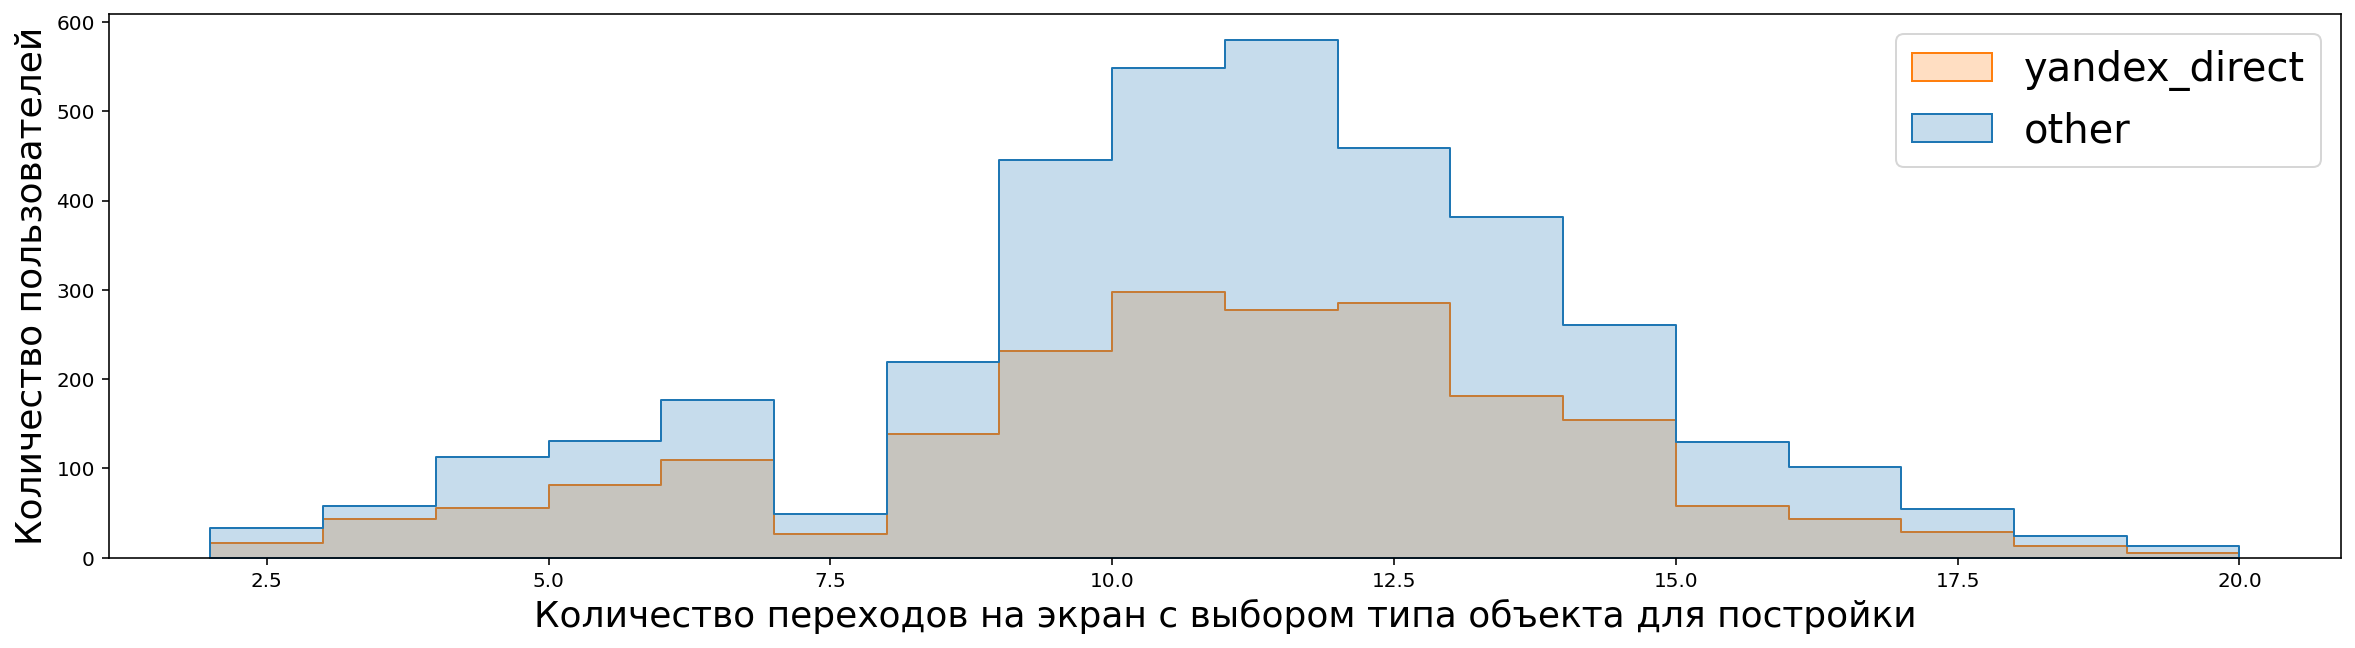

In [123]:
plt.figure(figsize=(20, 5))
sns.histplot(x="total_ad_shows", data=for_2_hyp_2_pivot, hue="channel", element="step", bins=18)
plt.xlabel('Количество переходов на экран с выбором типа объекта для постройки', fontsize = 18)
plt.ylabel ('Количество пользователей', fontsize = 18)
plt.legend(['yandex_direct', 'other'], fontsize=20)
plt.show();

Выразительных различий в форме распределения переменной "total_ad_shows" в зависимости от канала привлечения не выявлено. Типичное количество переходов на экран с выбором типа объекта постройки: от 9 до 13.  

In [124]:
for_2_hyp_2_pivot_yandex = for_2_hyp_2_pivot.loc[for_2_hyp_2_pivot.loc[:,'source'] == 'yandex_direct']
for_2_hyp_2_pivot_other = for_2_hyp_2_pivot.loc[for_2_hyp_2_pivot.loc[:,'source'] != 'yandex_direct']

In [125]:
print('Среднее количество переходов для игроков из yandex_direct:', for_2_hyp_2_pivot_yandex['total_ad_shows'].mean().round(decimals=1))
print('Среднее количество переходов для игроков из other', for_2_hyp_2_pivot_other['total_ad_shows'].mean().round(decimals=1))

Среднее количество переходов для игроков из yandex_direct: 10.4
Среднее количество переходов для игроков из other 10.5


Все выглядит так, что проверять статистическую значимость различия в среднем количестве переходов на экран с выбором типа объекта для постройки для игроков, привлеченных из yandex_direct и других каналов, нет необходимости в связи с очевидным отсуствием такого различия. 

## Проверка гипотез. 

### Проверка гипотезы о равенстве времени прохождения уровня. 

Мы определили, что, в среднем, для завершения уровня через победу над первым игроком необходимо 12 дней. А для завершения уровня через реализацию проекта, в среднем, необходимо 14 дней.

Нам предстоит проверить гипотезу о равенстве средних в двух независимых выборках.

Проверять гипотезу будем методом scipy.stats.ttest_ind (array1, array2, equal_var). Проверять гипотезы будем при alpha = 0,05.

<b>Сформулируем гипотезы.</b>

Нулевая гипотеза: среднее количество дней, необходимое на завершение уровня через победу над первым игроком и через реализацию проекта, не отличается.

Альтернативная гипотеза: среднее количество дней, необходимое на завершение уровня через победу над первым игроком и через реализацию проекта, отличается.

Дисперсии в выборках будем считать равными. 

In [126]:
for_1_hyp_win = for_1_hyp_win['time']
for_1_hyp_project = for_1_hyp_project['time']

alpha = 0.05

result = st.stats.ttest_ind(for_1_hyp_win, for_1_hyp_project)

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.363370007994992e-96
Отвергаем нулевую гипотезу


In [127]:
print('Отношение числа игроков, выбравших более быструю стратегию прохождения игры, к числу игроков, выбравших более медленную стратегию:',for_1_hyp_win.shape[0] / for_1_hyp_project.shape[0])

Отношение числа игроков, выбравших более быструю стратегию прохождения игры, к числу игроков, выбравших более медленную стратегию: 2.117363344051447


In [128]:
for_1_hyp_project.shape[0]

1866

Средние двух генеральных совокупностей не равны: принимаем альтернативную гипотезу о том, что среднее количество дней, необходимое на завершение уровня через победу над первым игроком и через реализацию проекта, отличается.

Выявлено, что в игре есть более популярная быстрая стратегия прохождения - через победу на первым игроком. Пользователи в два раза чаще выбирают эту стратегию. 

<b>Баланс в игре нарушен.</b> 

### Проверка гипотезы о равенстве прибыли, полученной от пользователей, привлеченных с помощью yandex_direct и youtube_channel_reklama.

Ранее мы определили, что средняя прибыль на одного пользователя, привлеченного из youtube_channel_reklama, составляет 0,25, а на привлеченного из yandex_direct - 0,19. 

Теперь проверим гипотезу о равенстве средних прибылей от пользователей, привлеченных из yandex_direct и из youtube_channel_reklama.

Предстоит проверить гипотезу о равенстве средних в двух независимых выборках.

Проверять гипотезу будем методом scipy.stats.ttest_ind (array1, array2, equal_var). Проверять гипотезы будем при alpha = 0,05.

<b>Сформулируем гипотезы.</b>

Нулевая гипотеза: средняя прибыль, полученная от пользователей, привлеченных с помощью yandex_direct и youtube_channel_reklama, не отличается.

Альтернативная гипотеза: средняя прибыль, полученная от пользователей, привлеченных с помощью yandex_direct и youtube_channel_reklama, отличается.

Дисперсии в выборках будем считать неравными.

In [129]:
for_2_hyp_merged_yandex = for_2_hyp_merged.loc[for_2_hyp_merged.loc[:,'source'] == 'yandex_direct']
for_2_hyp_merged_youtube = for_2_hyp_merged.loc[for_2_hyp_merged.loc[:,'source'] == 'youtube_channel_reklama']

In [130]:
for_2_hyp_merged_yandex = for_2_hyp_merged_yandex['profit']
for_2_hyp_merged_youtube = for_2_hyp_merged_youtube['profit']

alpha = 0.05

result = st.stats.ttest_ind(for_2_hyp_merged_yandex, for_2_hyp_merged_youtube, equal_var = False)

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.6920453213139284e-21
Отвергаем нулевую гипотезу



Средние двух генеральных совокупностей не равны: принимаем альтернативную гипотезу о том, что средняя прибыль, полученная от игроков, привлеченных из yandex_direct и youtube_channel_reklama, отличается.

<b>Таким образом, мы можем ранжировать рекламные каналы с точки зрения средней прибыльности игроков, которых они привлекают:</b>

1) youtube_channel_reklama (0,25)

2) yandex_direct (0,19)

3) instagram_new_adverts (0,02)

4) facebook_ads (-0,11)

### Проверка гипотезы о равенстве среднего количества переходов на экран с выбором типа объекта постройки в зависимости от способа прохождения уровня.

Объединим таблицы for_2_hyp_2_pivot и for_1_hyp, удалим лишние столбцы. 

In [131]:
for_3_hyp = for_2_hyp_2_pivot.merge(for_1_hyp, on=['user_id'], how='inner')

for_3_hyp = for_3_hyp.drop(columns = ['source', 'channel', 'time'])

for_3_hyp

,user_id,total_ad_shows,finish_type
0,001d39dc-366c-4021-9604-6a3b9ff01e25,8,win
1,003ee7e8-6356-4286-a715-62f22a18d2a1,8,win
2,004074f8-251a-4776-922c-8348dca1a2f6,12,win
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,8,win
4,0056c007-c082-43cc-bdef-afc49bca4cb9,3,win
...,...,...,...
5812,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,7,win
5813,ffe810f4-1a1f-464b-924d-6f120b0cb8df,16,win
5814,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,win
5815,fffb626c-5ab6-47c9-8113-2062a2f18494,9,win


In [ ]:
for_3_hyp.to_excel('Final_projecte.xlsx')

Рассчитаем среднее значения количества переходов, в зависимости от способа прохождения. 

In [65]:
for_3_hyp_pivot = for_3_hyp.pivot_table(index=['finish_type'], values='total_ad_shows', aggfunc=['mean'])
for_3_hyp_pivot = for_3_hyp_pivot.reset_index()
for_3_hyp_pivot.columns = ['finish_type', 'mean_count_ad_shows']
for_3_hyp_pivot

,finish_type,mean_count_ad_shows
0,project,12.647910
1,win,9.411541


Построим гистограмму с частотным распределением данных по переменной "total_ad_shows" ("Количество переходов на экран с выбором типа объекта для постройки"), с учетом способа завершения уровня.

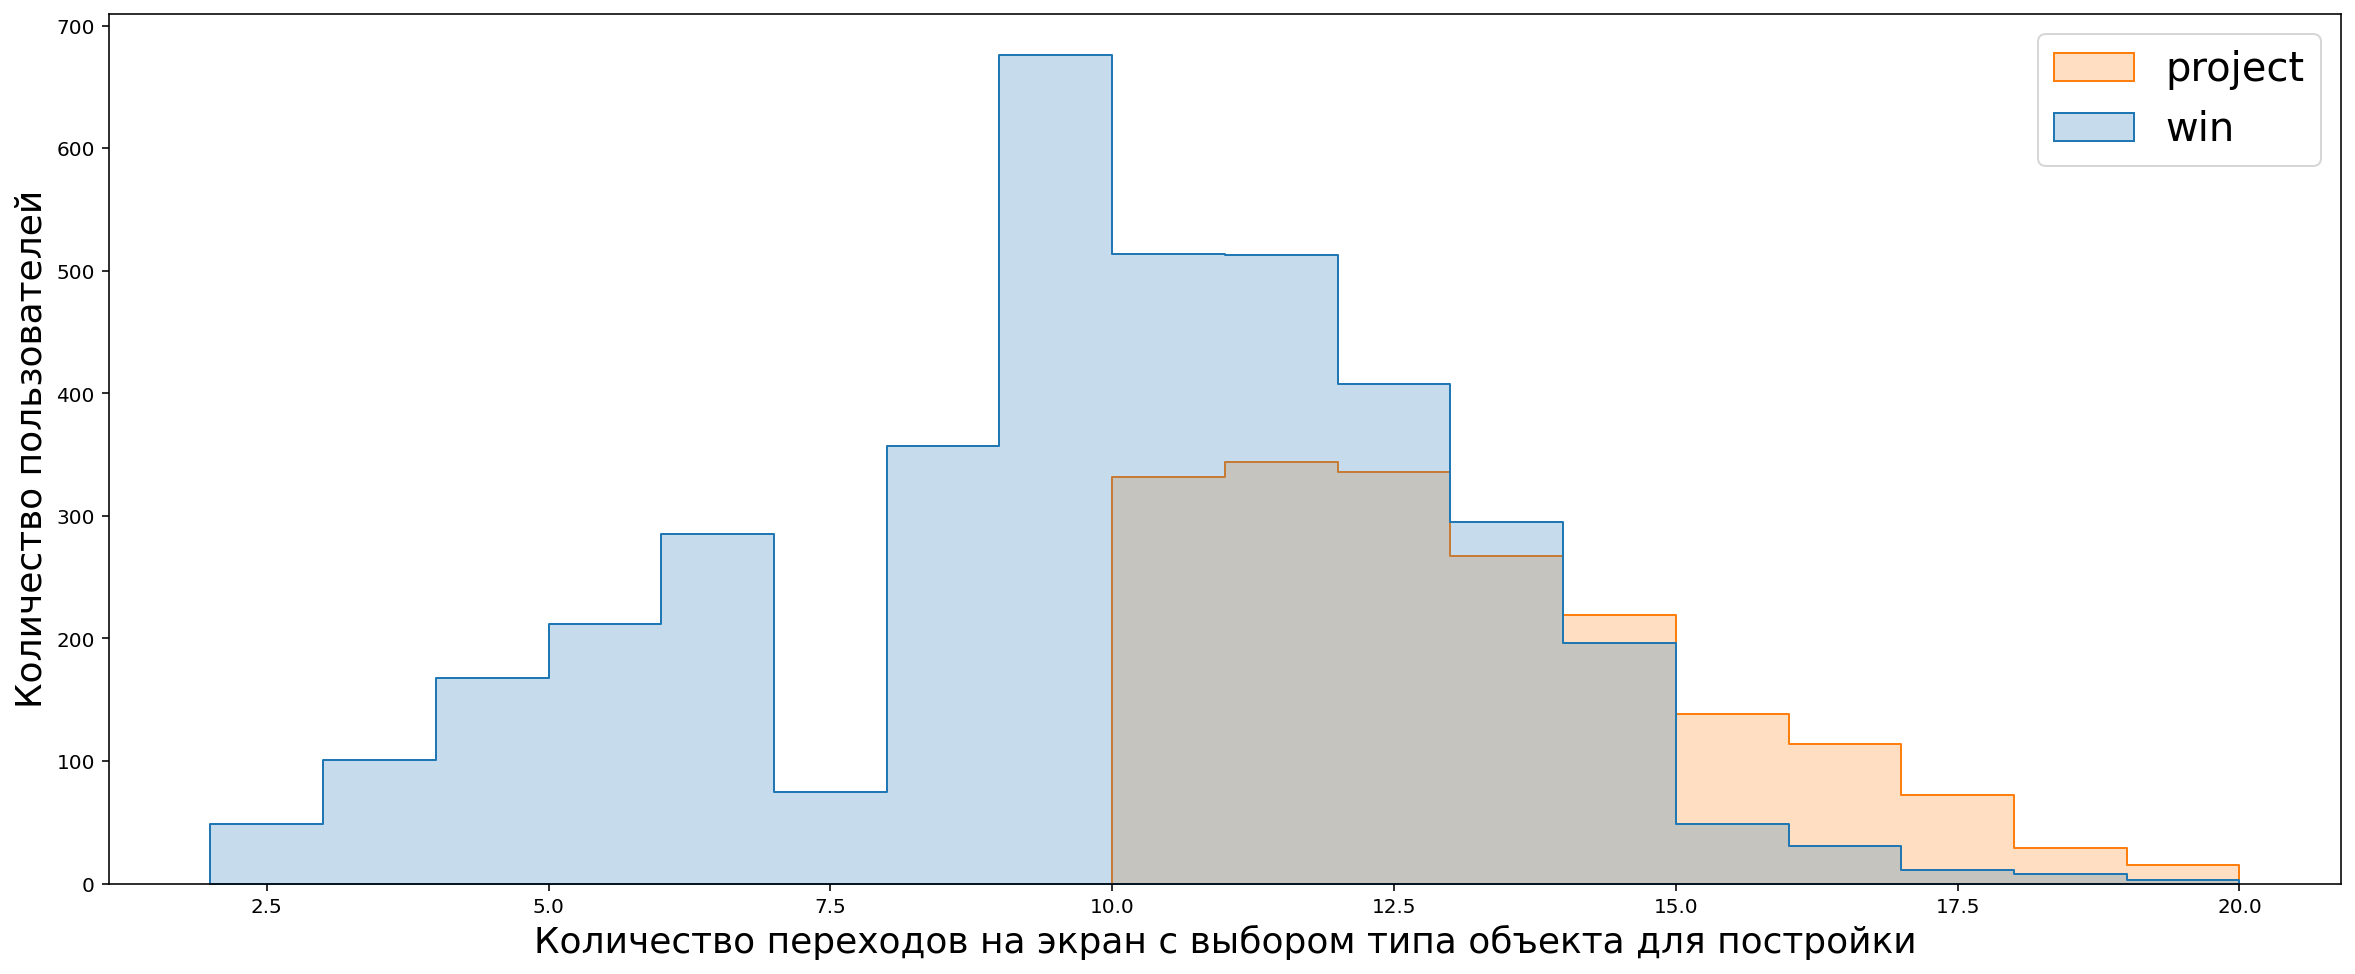

In [66]:
plt.figure(figsize=(20, 8))
sns.histplot(x="total_ad_shows", data=for_3_hyp, hue="finish_type", element="step", bins=18)
plt.xlabel('Количество переходов на экран с выбором типа объекта для постройки', fontsize = 18)
plt.ylabel ('Количество пользователей', fontsize = 18)
plt.legend(['project', 'win'], fontsize=20)
plt.show();

В среднем, количество переходов на экран с выбором типа объекта постройки меньше при завершении уровня через победу над первым игроком, чем через реализацию проекта (9,4 против 12,6 соответственно). 

In [67]:
for_3_hyp_project = for_3_hyp.loc[for_3_hyp.loc[:,'finish_type'] == 'project']
for_3_hyp_win = for_3_hyp.loc[for_3_hyp.loc[:,'finish_type'] == 'win']

for_3_hyp_project = for_3_hyp_project['total_ad_shows']
for_3_hyp_win = for_3_hyp_win['total_ad_shows']

alpha = 0.05

result = st.stats.ttest_ind(for_3_hyp_project, for_3_hyp_win)

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0
Отвергаем нулевую гипотезу


Средние двух генеральных совокупностей не равны: принимаем альтернативную гипотезу о том, что, в среднем, количество переходов на экран с выбором типа объекта постройки отличается в зависимости от способа завершения уровня.

## Выводы. 

Было выявлено, что, в среднем, для завершения уровня через победу над первым игроком необходимо 12 дней, а для завершения уровня через реализацию проекта, в среднем, необходимо 14 дней. Данное различие является статистически значимым. Игроки в два раза чаще выбирают более быструю стратегию. Более того, при завершении уровня через победу над первым игроком пользователи значительно в меньшем количестве (9,4 против 12,6) совершают переход на экран с выбором типа объекта постройки, соответственно, окупаемость этой стратегии будет существенно ниже.  

Также мы увидели, что можно ранжировать каналы привлечения пользователей в зависимости от средней прибыльности каждого из них. Так, наиболее прибыльными являются игроки, привлеченные из youtube_channel_reklama (0,25) и yandex_direct (0,19). Пользователи, привлеченные из instagram_new_adverts, находятся на уровне окупаемости (0,02). Пользователи из facebook_ads за исследуемый период не окупаются (-0,11). 

Обнаружен низкоэффективных источник - facebook_ads. Вложения в этот рекламный канал не окупаются. 

Не обнаружено различий в среднем количестве переходов на экран с выбором типа объекта постройки для завершивших первый уровень пользователей: для yandex_direct этот показатель составляет 10,4, для всех остальных каналов - 10,5.